In [1]:
import json
import pandas as pd
import numpy as np
import requests
from sodapy import Socrata
from api_keys import MyAppToken
import matplotlib.pyplot as plt
%matplotlib inline

import dtale

from datetime import datetime, date, timedelta
import time

# Set to True if you want "all the info messages"
debug = False;
# print(MyAppToken)

#checking the day of the month and printing the result, this is used to filter the dataframe later
today = date.today()
day = today.strftime("%d")
                     
todaysDate = time.strftime("%m-%d-%Y")
todaysFile = todaysDate + ".csv"
                     
if(debug):
    print("Day =", day);

In [2]:
# https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
# API docs: https://dev.socrata.com/foundry/data.cityofchicago.org/ijzp-q8t2
# Can download entire dataset as static CSV here: 
# https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD&api_foundry=true
crime_data = "ijzp-q8t2"
client = Socrata("data.cityofchicago.org", MyAppToken)

In [69]:
def GetData(start_date, end_date):
    max_rows = 2000000;
    where_clause = "Date BETWEEN '" + start_date + "' AND '" + end_date + "'";
    #where_clause = where_clause + " AND  'Primary Type' IN ('THEFT', 'BATTERY')"
    #where_clause = "'Primary Type' IN ('THEFT', 'BATTERY')"
    city = "Chicago";
    
    df = pd.DataFrame(
        client.get(
            crime_data, 
            where=where_clause,
            limit=max_rows,
            exclude_system_fields=True
        )
    )
    client.close()

    df["city"] = city;

    df['day'] = pd.DatetimeIndex(df['date']).day
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
    df['month_day'] = pd.to_datetime(df['date']).dt.strftime('%m-%d')

    df["primary_type"] = df["primary_type"].str.lower().str.title()
    df["description"] = df["description"].str.lower().str.title()
    df["location"] = df["location_description"].str.lower().str.title()    

    # Organize: 
    dfReturn = df[[
        "city"
        , "primary_type"
        , "description"
        , "date"
        , "month_day"
        , "day"
        , "month"
        , "year"
        , "location"
        , "latitude"
        , "longitude"
        , "domestic"
    ]]
    
    return dfReturn;

In [70]:
df2020 = GetData('2020-01-01', '2020-04-07');
df2019 = GetData('2019-01-01', '2019-04-07');
df2018 = GetData('2018-01-01', '2018-04-07');

In [71]:
df2019.head()

,city,primary_type,description,date,month_day,day,month,year,location,latitude,longitude,domestic
0,Chicago,Sex Offense,Aggravated Criminal Sexual Abuse,2019-01-01,01-01,1,1,2019,Residence,41.907072136,-87.731331357,False
1,Chicago,Offense Involving Children,Aggravated Criminal Sexual Abuse By Family Member,2019-01-01,01-01,1,1,2019,Apartment,41.853079711,-87.676856787,False
2,Chicago,Offense Involving Children,Child Abuse,2019-01-01,01-01,1,1,2019,Residence,41.875288057,-87.723999683,True
3,Chicago,Deceptive Practice,Financial Identity Theft Over $ 300,2019-01-01,01-01,1,1,2019,Apartment,41.929013312,-87.799805351,False
4,Chicago,Sex Offense,Agg Criminal Sexual Abuse,2019-01-01,01-01,1,1,2019,Apartment,41.896591951,-87.692793096,True


In [72]:
print(df2018.shape)
print(df2019.shape)
print(df2020.shape)

(63026, 12)
(62517, 12)
(55703, 12)


In [73]:
final = df2020.copy();
final = final.append(df2019);
final = final.append(df2018);
print(final.shape)
final = final.sort_values(["date"])

(181246, 12)


In [74]:
final.sample(5)

,city,primary_type,description,date,month_day,day,month,year,location,latitude,longitude,domestic
2304,Chicago,Assault,Simple,2020-01-04,01-04,4,1,2020,Residence,41.879246628,-87.696928482,False
62059,Chicago,Assault,Simple,2018-04-05,04-05,5,4,2018,"School, Public, Building",41.664592914,-87.63905866,True
6944,Chicago,Narcotics,Poss: Heroin(White),2019-01-10,01-10,10,1,2019,Residential Yard (Front/Back),41.888638298,-87.719777899,False
1428,Chicago,Other Offense,Harassment By Telephone,2018-01-02,01-02,2,1,2018,Residence,41.699421945,-87.611110897,True
57910,Chicago,Theft,Over $500,2018-03-30,03-30,30,3,2018,Bank,41.968808702,-87.675291143,False


In [94]:
final.to_csv("final_Chicago_data_detail.csv")

# Aggs and Group By

### By date

In [95]:
aggs_overall = final.groupby(["date", "month_day"]).agg({
        'day': [
            np.count_nonzero
        ]
}).reset_index() # Gets rid of auto aggregation/hierarchy
aggs_overall.columns = ["date", "month_day", "total_crimes_committed"]
aggs_overall.sort_values(["date"]);
aggs_overall.tail()
aggs_overall.to_csv("final_Chicago_data_total_crime_by_date.csv")

### By date and type

In [96]:
aggs_by_date_type = final.groupby(["date", "month_day", "primary_type"]).agg({
        'day': [
            np.count_nonzero
        ]
}).reset_index() # Gets rid of auto aggregation/hierarchy

aggs_by_date_type.columns = ["date", "month_day", "primary_type", "crimes_committed"]
#aggs_by_date_type["date"] = pd.to_datetime(aggs_by_date_type["date"]);
#aggs_by_date_type.set_index('date')
# resample() requires a DateTimeIndex
aggs_by_date_type = aggs_by_date_type.set_index(pd.DatetimeIndex(aggs_by_date_type['date']))
aggs_by_date_type = aggs_by_date_type.drop(['date'], axis=1)
aggs_by_date_type.head(20)
aggs_by_date_type.to_csv("final_Chicago_data_total_crime_by_date_and_type.csv")

# Load CSVs


------
### By date

In [97]:
def timestamp_to_datetime(timestamp):    
    return datetime.fromtimestamp(float(timestamp))

dfCSV = pd.read_csv(
    'final_Chicago_data_total_crime_by_date.csv', 
    names=["index", "date", "month_day", "crimes_committed"]
)

dfCSV["date"] = pd.to_datetime(dfCSV["date"], format='%Y-%m-%d', errors='coerce')
dfCSV = dfCSV.set_index('date') # creates a DateTimeIndex - req'd by .resample()
dfCSV = dfCSV.drop(['index'], axis=1)

# drop the first "garbage" row
dfCSV = dfCSV.iloc[1:]
dfCSV.head()

,month_day,crimes_committed
date,,
2018-01-01,01-01,895
2018-01-02,01-02,559
2018-01-03,01-03,574
2018-01-04,01-04,601
2018-01-05,01-05,663


In [98]:
# set number of days and standard deviations to use for rolling 
# lookback period for Bollinger band calculation
window = 3
no_of_std = 1.5

# calculate rolling mean and standard deviation
rolling_mean = dfCSV['crimes_committed'].rolling(window).mean()
rolling_std = dfCSV['crimes_committed'].rolling(window).std()

# create two new DataFrame columns to hold values of upper and lower Bollinger bands
dfCSV['Rolling Mean'] = rolling_mean
dfCSV['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
dfCSV['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

dfCSV.head()

,month_day,crimes_committed,Rolling Mean,Bollinger High,Bollinger Low
date,,,,,
2018-01-01,01-01,895,NaN,NaN,NaN
2018-01-02,01-02,559,NaN,NaN,NaN
2018-01-03,01-03,574,676.000000,960.711696,391.288304
2018-01-04,01-04,601,578.000000,609.925695,546.074305
2018-01-05,01-05,663,612.666667,681.115553,544.217781


In [99]:
dfCSV_2018 = dfCSV.loc["2018-01-01": "2018-04-07"].copy()
dfCSV_2019 = dfCSV.loc["2019-01-01": "2019-04-07"].copy()
dfCSV_2020 = dfCSV.loc["2020-01-01": "2020-04-07"].copy()

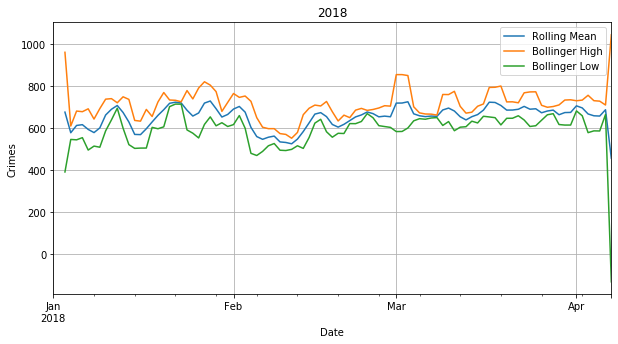

In [100]:
dfCSV_2018[['crimes_committed','Rolling Mean', 'Bollinger High','Bollinger Low']].plot(
    grid=True,
    figsize=(10,5)
)
plt.title('2018')
plt.ylabel('Crimes')
plt.xlabel('Date')
plt.legend()
plt.show()

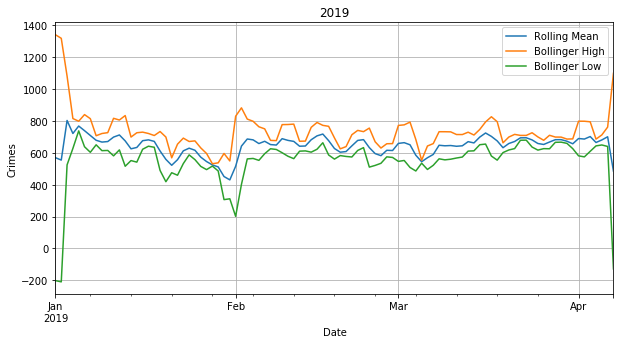

In [101]:
dfCSV_2019[['crimes_committed','Rolling Mean', 'Bollinger High','Bollinger Low']].plot(
    grid=True,
    figsize=(10,5)
)
plt.title('2019')
plt.ylabel('Crimes')
plt.xlabel('Date')
plt.legend()
plt.show()

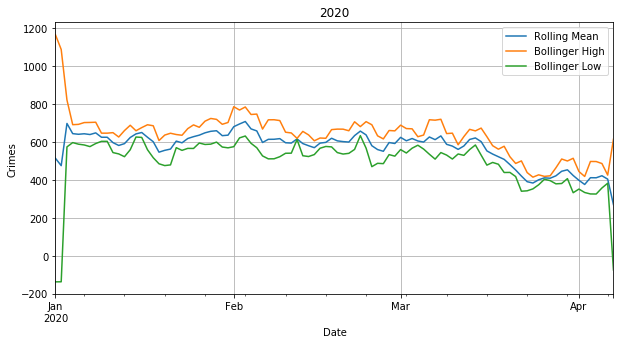

In [102]:
dfCSV_2020[['crimes_committed','Rolling Mean', 'Bollinger High','Bollinger Low']].plot(
    grid=True,
    figsize=(10,5)
)
plt.title('2020')
plt.ylabel('Crimes')
plt.xlabel('Date')
plt.legend()
plt.show()

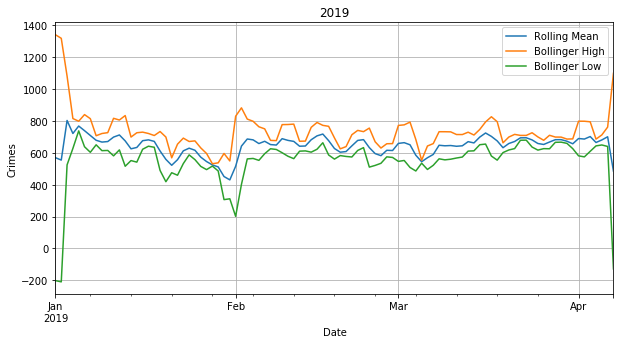

In [103]:
dfCSV_2019[['crimes_committed','Rolling Mean', 'Bollinger High','Bollinger Low']].plot(
    grid=True,
    figsize=(10,5)
)
plt.title('2019')
plt.ylabel('Crimes')
plt.xlabel('Date')
plt.legend()
plt.show()

In [110]:
dfCSV_2018.columns = ["month_day", "crimes", "3day_mean", "high", "low"]
dfCSV_2019.columns = ["month_day", "crimes", "3day_mean", "high", "low"]
dfCSV_2020.columns = ["month_day", "crimes", "3day_mean", "high", "low"]

dfCSV_2018["crimes"] = pd.to_numeric(dfCSV_2018["crimes"])
dfCSV_2019["crimes"] = pd.to_numeric(dfCSV_2019["crimes"])
dfCSV_2020["crimes"] = pd.to_numeric(dfCSV_2020["crimes"])

In [111]:
dfCSV_2018

,month_day,crimes,3day_mean,high,low
date,,,,,
2018-01-01,01-01,895,NaN,NaN,NaN
2018-01-02,01-02,559,NaN,NaN,NaN
2018-01-03,01-03,574,676.000000,960.711696,391.288304
2018-01-04,01-04,601,578.000000,609.925695,546.074305
2018-01-05,01-05,663,612.666667,681.115553,544.217781
2018-01-06,01-06,585,616.333333,678.131392,554.535275
2018-01-07,01-07,533,593.666667,691.814514,495.518819
2018-01-08,01-08,618,578.666667,642.945357,514.387977
2018-01-09,01-09,652,601.000000,692.941558,509.058442


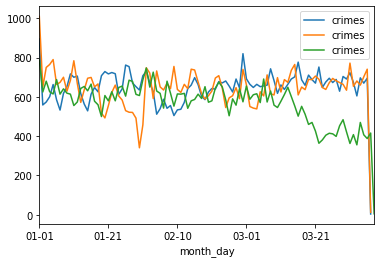

In [114]:
ax = dfCSV_2018.plot(
    x='month_day'
    , y='crimes'
) 
dfCSV_2019.plot(
    ax=ax,
    x='month_day',
    y='crimes'
) 
dfCSV_2020.plot(
    ax=ax,
    x='month_day',
    y='crimes'
) 

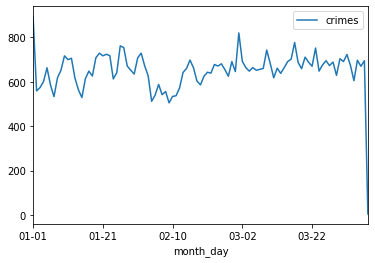

In [115]:
dfCSV_2018.plot(
    x='month_day'
    , y='crimes'
) 

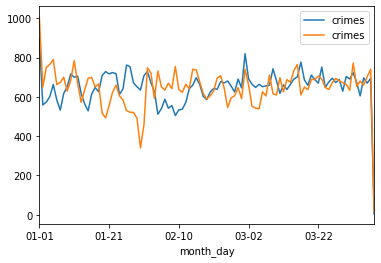

In [116]:
ax = dfCSV_2018.plot(
    x='month_day'
    , y='crimes'
) 
dfCSV_2019.plot(
    ax=ax,
    x='month_day',
    y='crimes'
) 

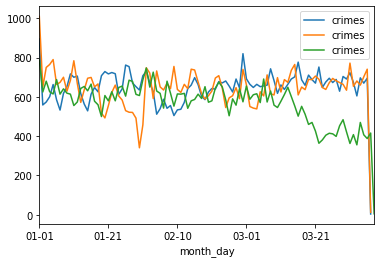

In [117]:
ax = dfCSV_2018.plot(
    x='month_day'
    , y='crimes'
) 
dfCSV_2019.plot(
    ax=ax,
    x='month_day',
    y='crimes'
) 
dfCSV_2020.plot(
    ax=ax,
    x='month_day',
    y='crimes'
) 